In [ ]:
%env DATA_DIR=$HOME/datasets
%env LOG_LEVEL=INFO
%env BATCH_SIZE=64
%env OPTIM_LR=0.001
%env OPTIM_M=0.8
%env TRAIN_EPOCHS=100
%env EXC_RESUME=1
%env DATASET_NAME=QPM_species
%env MANIFOLD_D=128
%env MODEL_NAME=resnet50_simclr
# %env OOD=4

In [2]:
import lightning.pytorch as pl
import numpy as np
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger

from config import Config, load_config
from datasets import get_data
from models import get_model

model_id = "pbxu4k88"

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

config = load_config()

In [4]:
# initialize data attributes and loaders
config.load_data()
config.print_labels()
dm = config.datamodule
assert dm

In [5]:
dm.setup("test")

Dataset type train label type: species
Loaded 375443 images
Dataset type val label type: species
Loaded 48562 images
Dataset type test label type: species
Loaded 48790 images
Performing ind/ood split


100%|██████████| 375443/375443 [00:10<00:00, 35675.09it/s]


Train - OK


100%|██████████| 48562/48562 [00:01<00:00, 35786.15it/s]


Val - OK


100%|██████████| 48790/48790 [00:01<00:00, 35512.94it/s]

Test - OK
Performed ind/ood split
375443 48562 48790 0


In [6]:
model = config.get_model()

In [7]:
from pathlib import Path
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/uq_project/model-{model_id}:best")
model = model.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-pbxu4k88:best, 300.27MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.2


In [8]:
test_loader = dm.test_dataloader()

In [10]:
from models.common import edl_probs
from tqdm.auto import tqdm

embeddings = []
labels = []
strains = []

for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, s = batch
    x = x.float().cuda()
    y = y.long().cpu()
    s = s.long().cpu()
    proj_a, proj_b, logits = model(x)
    embedding = proj_a.detach().flatten(start_dim=1).cpu().numpy()
    embeddings.extend(embedding)
    labels.extend(y.detach().numpy())
    strains.extend(s.detach().numpy())
print("OK")

100%|██████████| 763/763 [00:05<00:00, 133.61it/s]


OK


In [11]:
embeddings = np.array(embeddings)
labels = np.array(labels)
strains = np.array(strains)
print(embeddings.shape)
print(labels.shape)
print(strains.shape)

(48790, 1024)
(48790,)
(48790,)


In [12]:
from sklearn.manifold import TSNE

tsne_emb = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embeddings)
print(tsne_emb.shape)

(48790, 2)


In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

emb_d1, emb_d2 = tsne_emb.T
label = [config.labels[i] for i in labels]
strain = [config.datamodule.strains[i] for i in strains]
data = pd.DataFrame(dict(x=emb_d1, y=emb_d2, label=label, strain=strain))

<Axes: xlabel='x', ylabel='y'>

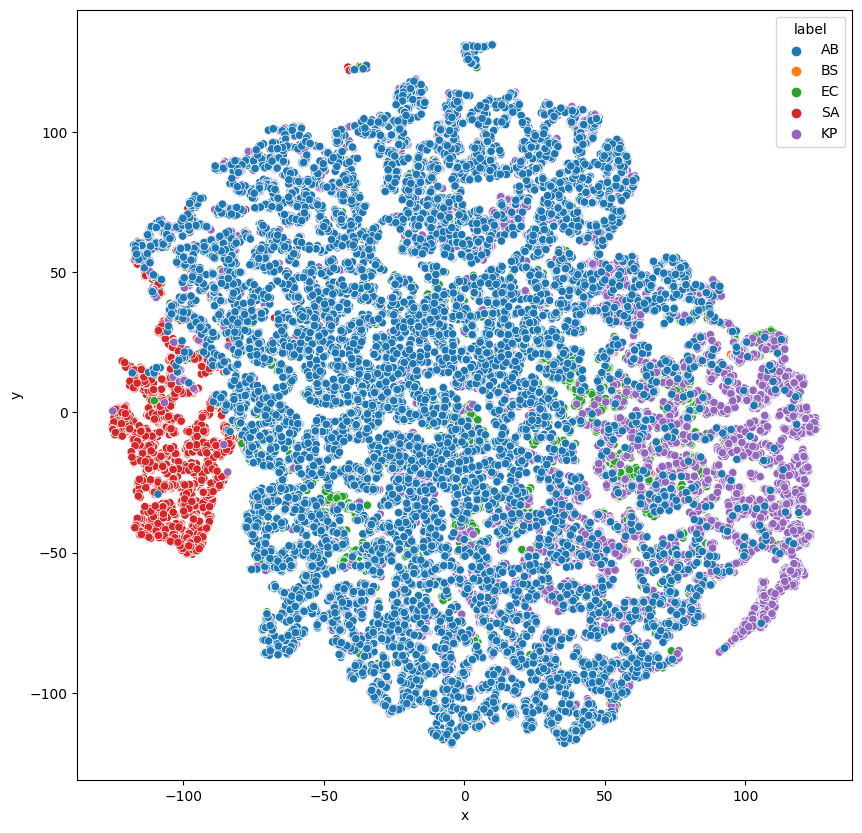

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data, x="x", y="y", hue="label")

<Axes: xlabel='x', ylabel='y'>

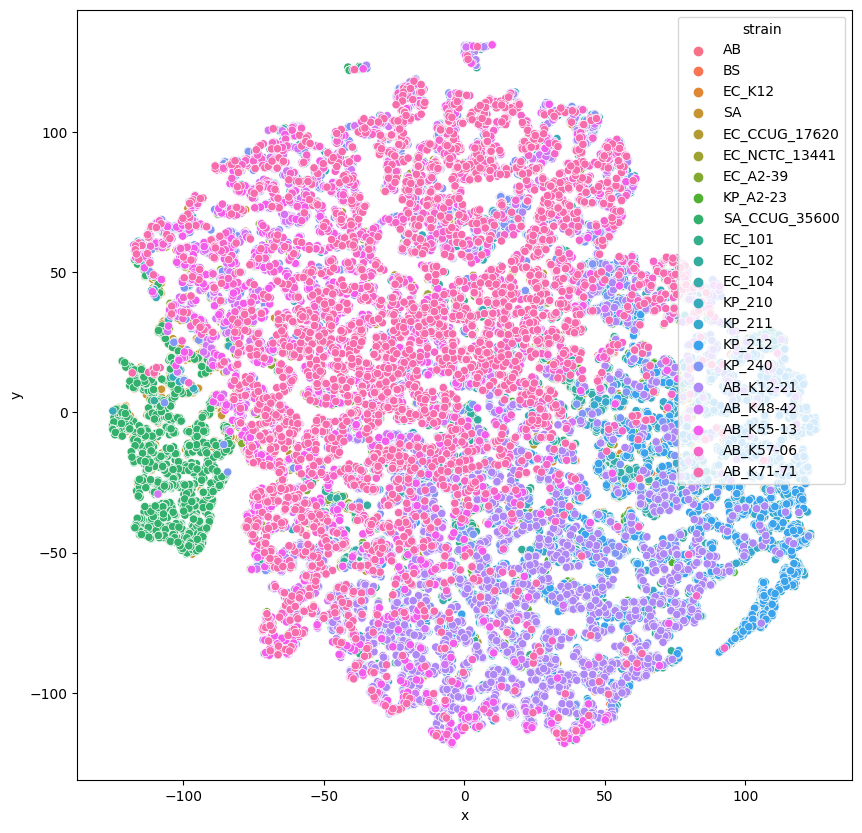

In [25]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data, x="x", y="y", hue="strain")

In [17]:
np.savez('QPM_species_resnet50_simclr_M128.npz', { 'z': embeddings, 's': strains })

In [18]:
import scipy
scipy.io.savemat('QPM_species_resnet50_simclr_M128.mat', { 'z': embeddings, 's': strains })